In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from parameters import ParameterSpace, ParameterRange, ParameterSet
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import h5py
import scipy.signal as ss
from example_network_parameters import (networkParameters, population_names,
                                        population_sizes)
from lfpykernels import KernelApprox, GaussCylinderPotential
import example_network_methods as methods
import example_network_parameters as params
import scipy.stats as st
from copy import deepcopy
from plotting import draw_lineplot, annotate_subplot
import plotting
from lfpykit import CurrentDipoleMoment, LaminarCurrentSourceDensity
import json
import hashlib
import pandas as pd
from time import time
import neuron

In [3]:
plt.rcParams.update(plotting.rcParams)
golden_ratio = plotting.golden_ratio
figwidth = plotting.figwidth

In [4]:
PS0 = ParameterSpace('PS0.txt')
PS1 = ParameterSpace('PS1.txt')
PS2 = ParameterSpace('PS2.txt')

In [5]:
neuron.load_mechanisms('mod')

True

In [6]:
TRANSIENT = 2000
dt = networkParameters['dt']
tau = 100  # max time lag relative to spike for kernel predictions
tau_trunc = 50 # max time lag for shown in plot

In [7]:
# plt.mlab.psd/csd settings
Fs = 1000 / dt
NFFT = 1024
noverlap = 768

In [8]:
# low-pass filter settings
N = 2  # filter order
rp = 0.1  # ripple in passband (dB)
rs = 40.  # minimum attenuation required in the stop band (dB)
fc = 100.  # critical frequency (Hz)

# filter coefficients on 'sos' format
sos_ellip = ss.ellip(N=N, rp=rp, rs=rs, Wn=fc, btype='lp', fs=Fs, output='sos')

In [9]:
# Do not investigate models with biophys='lin'
PS2['biophys'] = ParameterRange(['frozen'])
PS2

{'weight_EE': ParameterRange([0.00015]),
 'weight_IE': ParameterRange([0.000125]),
 'weight_EI': ParameterRange([0.0045]),
 'weight_II': ParameterRange([0.002]),
 'weight_scaling': ParameterRange([1.0]),
 'biophys': ParameterRange(['frozen']),
 'n_ext': ParameterRange([[465, 160]]),
 't_E': ParameterRange([200.0]),
 't_I': ParameterRange([400.0]),
 'g_eff': ParameterRange([True])}

In [10]:
# Define iterable parameter space for nu_X&nu_ext (relative scaling) and V_rest (offset)
PS3 = ParameterSpace(
    dict(
        nu_X_scaling=ParameterRange(np.linspace(0., 2., 21)),
        V_rest_offset=ParameterRange(np.linspace(-10., 10., 21)),
    )
)
PS3, PS3.num_conditions()

({'nu_X_scaling': ParameterRange(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
         1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])),
  'V_rest_offset': ParameterRange(array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
           1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]))},
 441)

In [11]:
# figure out which real LFP to compare with
for pset in PS1.iter_inner():
    weight_EE = pset['weight_EE']
    weight_IE = pset['weight_IE']
    weight_EI = pset['weight_EI']
    weight_II = pset['weight_II']
    weight_scaling = pset['weight_scaling']
    pset_0 = ParameterSet(dict(weight_EE=weight_EE,
                               weight_IE=weight_IE,
                               weight_EI=weight_EI,
                               weight_II=weight_II,
                               weight_scaling=weight_scaling,
                               n_ext=PS0['n_ext'].value))
    js_0 = json.dumps(pset_0, sort_keys=True).encode()
    md5_0 = hashlib.md5(js_0).hexdigest()
    OUTPUTPATH_REAL = os.path.join('output', md5_0)

    break
print(f'comparing with ground truth dataset: {OUTPUTPATH_REAL}')

comparing with ground truth dataset: output/adb947bfb931a5a8d09ad078a6d256b0


In [12]:
# Compute average firing rate of presynaptic populations X
mean_nu_X = methods.compute_mean_nu_X(params, OUTPUTPATH_REAL,
                                 TRANSIENT=TRANSIENT)
mean_nu_X

{'E': 2.57099609375, 'I': 5.0578125}

In [13]:
# Extract median soma voltages from actual network simulation and
# assume this value corresponds to Vrest.
Vrest_Y = {}
with h5py.File(os.path.join(OUTPUTPATH_REAL, 'somav.h5'
                            ), 'r') as f:
    for Y in params.population_names:
        Vrest_Y[Y] = np.median(f[Y][()][:, TRANSIENT:])
Vrest_Y

{'E': -70.55210816072011, 'I': -69.35921775516559}

In [14]:
# compute firing rate time series of "real" network (as spikes per time bin of width dt)
nu_X = dict()
tstop = networkParameters['tstop']
bins = (np.arange(0, tstop / dt + 2)
        * dt - dt / 2)
with h5py.File(os.path.join(OUTPUTPATH_REAL, 'spikes.h5'), 'r') as f:
    for i, X in enumerate(params.population_names):
        hist = np.histogram(np.concatenate(f[X]['times']), bins=bins)[0]
        nu_X[X] = hist.astype(float)

In [15]:
# ground truth dataset for comparison
probe = 'CurrentDipoleMoment'
with h5py.File(os.path.join(OUTPUTPATH_REAL, f'{probe}.h5'),
               'r') as f:
    data_gt = f['data']['imem'][-1, ]

# low pass filter
data_gt_lp = ss.sosfiltfilt(sos_ellip, data_gt)

In [16]:
# precompute standard deviations
data_gt_std = data_gt[int(TRANSIENT // dt):].std()
data_gt_lp_std = data_gt_lp[int(TRANSIENT // dt):].std()

In [17]:
# spike-dipole moment kernel approximations
# obtained using the KernelApprox class

# kernel container
H_YX_pred = dict()
for k, pset in enumerate(PS2.iter_inner()):
    for pset_inner in PS3.iter_inner():
        # sorted json dictionary
        pset = {**pset, **pset_inner}  # merge dicts
        js = json.dumps(pset, sort_keys=True).encode()
        md5 = hashlib.md5(js).hexdigest()

        # parameters
        weight_EE = pset['weight_EE']
        weight_IE = pset['weight_IE']
        weight_EI = pset['weight_EI']
        weight_II = pset['weight_II']
        weight_scaling = pset['weight_scaling']
        biophys = pset['biophys']
        n_ext = pset['n_ext']
        g_eff = pset['g_eff']

        t_X = TRANSIENT  # presynaptic activation time

        # define biophysical membrane properties
        if biophys == 'pas':
            custom_fun = [methods.set_pas_hay2011, methods.make_cell_uniform]
        elif biophys == 'frozen':
            custom_fun = [methods.set_frozen_hay2011, methods.make_cell_uniform]
        elif biophys == 'frozen_no_Ih':
            custom_fun = [methods.set_frozen_hay2011_no_Ih, methods.make_cell_uniform]
        elif biophys == 'lin':
            custom_fun = [methods.set_Ih_linearized_hay2011, methods.make_cell_uniform]
        else:
            raise NotImplementedError

        # synapse max. conductance (function, mean, st.dev., min.):
        weights = np.array([[weight_EE, weight_IE],
                            [weight_EI, weight_II]]) * weight_scaling


        # set up recording of current dipole moments.
        current_dipole_moment = CurrentDipoleMoment(cell=None)

        # create rescaled nu_X parameter for KernelApprox class
        nu_X_scaled = {}
        for X in params.population_names:
            nu_X_scaled.update({X:mean_nu_X[X] * pset['nu_X_scaling']})


        # kernel container
        H_YX_pred[md5] = dict()

        for i, (X, N_X) in enumerate(zip(params.population_names,
                                         params.population_sizes)):
            for j, (Y, N_Y, morphology) in enumerate(zip(params.population_names,
                                                         params.population_sizes,
                                                         params.morphologies)):
                # update cellParameters dict
                cellParameters = deepcopy(params.cellParameters)
                cellParameters.update(dict(
                    morphology=morphology,
                    custom_fun=custom_fun,
                    custom_fun_args=[dict(Vrest=Vrest_Y[Y] + pset['V_rest_offset']), 
                                     dict(Vrest=Vrest_Y[Y] + pset['V_rest_offset'])],
                ))

                # some inputs must be lists
                synapseParameters = [
                    dict(weight=weights[ii][j],
                         syntype='Exp2Syn',
                         **params.synapseParameters[ii][j])
                    for ii in range(len(params.population_names))]
                synapsePositionArguments = [
                    params.synapsePositionArguments[ii][j]
                    for ii in range(len(params.population_names))]

                
                # Create kernel approximator object
                kernel = KernelApprox(
                    X=params.population_names,
                    Y=Y,
                    N_X=np.array(params.population_sizes),
                    N_Y=N_Y,
                    C_YX=np.array(params.connectionProbability[i]),
                    cellParameters=cellParameters,
                    populationParameters=params.populationParameters['pop_args'],
                    multapseFunction=params.multapseFunction,
                    multapseParameters=[params.multapseArguments[ii][j] for ii in range(len(params.population_names))],
                    delayFunction=params.delayFunction,
                    delayParameters=[params.delayArguments[ii][j] for ii in range(len(params.population_names))],
                    synapseParameters=synapseParameters,
                    synapsePositionArguments=synapsePositionArguments,
                    extSynapseParameters=params.extSynapseParameters,
                    nu_ext=1000. / params.netstim_interval * pset['nu_X_scaling'],
                    n_ext=n_ext[j],
                    nu_X=nu_X_scaled,
                )

                # make kernel predictions
                H_YX_pred[md5]['{}:{}'.format(Y, X)] = kernel.get_kernel(
                    probes=[current_dipole_moment],
                    Vrest=Vrest_Y[Y] + pset['V_rest_offset'], dt=dt, X=X, t_X=t_X, tau=tau,
                    g_eff=g_eff,
                )

In [18]:
# compute R^2 and r_STD metrics between ground truth and approximated signals equal to sum_X sum_Y (nu_X * H_YX)

# container
df = pd.DataFrame(columns=['md5', 'R2', 'r_STD', 'signal'])

for k, pset in enumerate(PS2.iter_inner()):
    for pset_inner in PS3.iter_inner():
        # sorted json dictionary
        pset = {**pset, **pset_inner}  # merge dicts
        js = json.dumps(pset, sort_keys=True).encode()
        md5 = hashlib.md5(js).hexdigest()
        
        # approximate signals using computed kernels
        data = None
        for X in population_names:
            for Y in population_names:
                if data is None:
                    data = np.zeros(nu_X[X].size)
                # for h, h_YX in enumerate(H_YX_pred[md5]['{}:{}'.format(Y, X)][probe]):
                data = data + np.convolve(nu_X[X], H_YX_pred[md5]['{}:{}'.format(Y, X)][probe][-1, :], 'same')
        # low pass filter
        data_lp = ss.sosfiltfilt(sos_ellip, data)
        
        # Pearson correlation coefficients
        Pcc = np.corrcoef(data_gt[int(TRANSIENT // dt):], 
                          data[int(TRANSIENT // dt):])[1:, :1].diagonal()
        Pcc_lp = np.corrcoef(data_gt_lp[int(TRANSIENT // dt):],
                             data_lp[int(TRANSIENT // dt):])[1:, :1].diagonal()

        scaling = data[int(TRANSIENT  // dt):].std() / data_gt_std
        scaling_lp = data_lp[int(TRANSIENT // dt):].std() / data_gt_lp_std

        df = df.append([
                pd.DataFrame(
                    data={'md5': md5, 'R2': Pcc**2, 'r_STD': scaling, 'signal': 'raw'}, 
                    index=[0]
                ),
                pd.DataFrame(
                    data={'md5': md5, 'R2': Pcc_lp**2, 'r_STD': scaling_lp, 'signal': 'LP'}, 
                    index=[0]
                ),
                ],
            ignore_index=True)

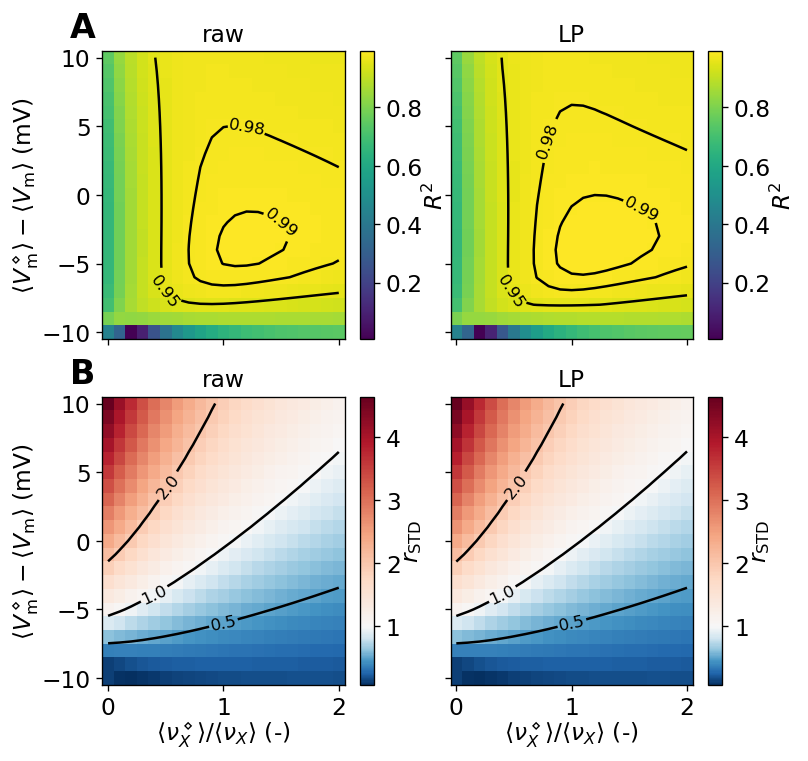

In [20]:
# plot R2 and r_STD metrics as function of nu_X_scaling and V_rest_offset
fig, axes = plt.subplots(PS2.num_conditions() * 2, 2, figsize=(figwidth / 2, figwidth / 2), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.15)

for i, ax in enumerate(axes[:, 0]):
    annotate_subplot(ax, ncols=2, nrows=2, letter='ABCDEFGHIJ'[i], linear_offset=0.04)

for pset in PS2.iter_inner():
    
    # containers for plotting
    dim, keys = PS3.parameter_space_dimension_labels()
    for k, metric in enumerate(['R2', 'r_STD']):
        if metric == 'R2':
            cmap = 'viridis'
            norm = colors.Normalize(vmin=df[metric].min(), vmax=df[metric].max())
        elif metric == 'r_STD':
            cmap = 'RdBu_r'
            norm = colors.TwoSlopeNorm(vcenter=1, vmin=df[metric].min(), vmax=df[metric].max())
        else:
            raise NotImplementedError
        
        metric_nice = '$R^2$' if metric == 'R2' else '$r_\mathrm{STD}$'
        
        h = 0
        for signal in ['raw', 'LP']:
            imdata = np.zeros(dim)
            for i, value_i in enumerate(PS3[keys[0]]):
                for j, value_j in enumerate(PS3[keys[1]]):
                    pset = {**pset, **{keys[0]: value_i, keys[1]:value_j}}  # merge dicts
                    js = json.dumps(pset, sort_keys=True).encode()
                    md5 = hashlib.md5(js).hexdigest()
                    imdata[i, j] = df[(df['md5'].values==md5) & (df['signal'].values==signal)][metric].values
            
            
            ax = axes[k, h]
            
            im = ax.pcolormesh(list(PS3[keys[1]]), list(PS3[keys[0]]), imdata, shading='auto', norm=norm, cmap=cmap)
            # add a single contour line
            if metric == 'R2':
                levels = [0.95, 0.98, 0.99]  # explained variance
            else: 
                levels = [0.5, 1, 2.0]  # 
            CS = ax.contour(list(PS3[keys[1]]), list(PS3[keys[0]]), imdata, levels=levels, colors=['k'])
            ax.clabel(CS, CS.levels, inline=True, fontsize=10)
            
            biophys = pset['biophys']
            ax.set_title(f'{signal}')
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label(metric_nice)
            if h == 0:
                ax.set_ylabel(r'$\langle V_\mathrm{m}^\diamond \rangle - \langle V_\mathrm{m} \rangle$ (mV)')
            if k == 1:
                ax.set_xlabel(r'$\langle \nu_X^\diamond \rangle / \langle \nu_X \rangle$ (-)')
            h += 1

fig.savefig(os.path.join('figures', 'figure10.pdf'), bbox_inches='tight')